# 利用ground truth,制作点特征的label

移动点云数据

In [ ]:
import shutil
import os

path = 

for line in lines:
    parts = line.strip().split(' ', 1)  # 使用第一个空格来分割
    if len(parts) == 2:  # 确保行正确分割为两部分
        index, path = parts
        # print(f"序号: {index}, 路径: {path}")
        source_path = os.path.join(path, 'velodyne_points/data')
        target_path = os.path.join('../datasets/sequence_point', f"{index}")
        target_path = os.path.join(target_path, 'velodyne')
        shutil.copytree(source_path, target_path)
        print(f"成功复制：{source_path} 到 {target_path}")


读取每个GT，将GT转换成velo to velo

In [ ]:
import numpy as np

In [ ]:
def read_calib_file(filepath):
    calib_data = {}
    with open(filepath, 'r') as file:
        for line in file:
            key, value = line.split(':', 1)
            if key == 'R' or key == 'T':
                calib_data[key] = value.strip()

    return calib_data


def RT_matrix_maker(calib_data):
    if "R" in calib_data and "T" in calib_data:
        R_values = [float(x) for x in calib_data["R"].split()]
        T_values = [float(x) for x in calib_data["T"].split()]

        # 构造变换矩阵
        R_matrix = np.array(R_values).reshape(3, 3)
        T_vector = np.array(T_values).reshape(3, 1)
        RT_matrix = np.hstack((R_matrix, T_vector))
        RT_matrix = np.vstack((RT_matrix, [0, 0, 0, 1]))

        RT_matrix
    else:
        RT_matrix = None

    return RT_matrix

In [ ]:


RT_matrix = np.eye(4)
for line in lines:
    parts = line.strip().split(' ', 1)  # 使用第一个空格来分割
    if len(parts) == 2:  # 确保行正确分割为两部分
        index, path = parts
        

        calib_filepath = os.path.join(os.path.dirname(path), 'calib_velo_to_cam.txt')
        calib_data = read_calib_file(calib_filepath)
        RT_matrix = RT_matrix_maker(calib_data)
        RT_matrix_inv = np.linalg.inv(RT_matrix)
        gt_filepath = os.path.join(path, '{}.txt'.format(index))

    with open(gt_filepath, 'r') as f:
        liness = f.readlines()

    transformed_lines = []
    print(len(liness))
    for line in liness:
        pose = line.strip().split()  # 切分每行数据
        
        # 提取位姿变换矩阵并变为4x4
        pose_matrix = np.eye(4)
        
        pose_matrix[:3, :] = np.array(pose).reshape(3, 4).astype(float)

        # 旋转矩阵
        transformed_matrix = RT_matrix_inv @ pose_matrix @ RT_matrix

        # 从变换矩阵中提取变换后的位姿
        transformed_pose = transformed_matrix[:3, :].flatten()
        transformed_lines.append(" ".join(map(str, transformed_pose)))
    
    data_matrices = []
    for line in transformed_lines:
        pose = line.strip().split()  # 切分每行数据
        data_matrix = np.eye(4)
        data_matrix[:3, :] = np.array(pose).reshape(3, 4).astype(float)
        data_matrices.append(data_matrix)

    data_matrices = np.array(data_matrices)
    print(data_matrices.shape)
    
    # T_filename = os.path.join('../datasets/sequence_point/{}'.format(index), 'T')
    # os.mkdir(T_filename)
    # for i in range(data_matrices.shape[0] - 1):
    #     T = np.dot(np.linalg.inv(data_matrices[i+1]), data_matrices[i])
    #     np.savetxt(os.path.join(T_filename, '{:010d}.txt'.format(i)), T)
    #T 是从 i+1 到 i 的变换矩阵
        
       



In [ ]:
import os
data_list = {'00','01','02','04','05','06','07','09','10'}
path = '../datasets/sequence_point/'
for idx in data_list:
    path_data = os.path.join(path, idx)
    velo_path = os.path.join(path_data, 'velodyne')
    entries = os.listdir(velo_path)
    file_count_velo = sum(1 for entry in entries)
    
    T_path = os.path.join(path_data, 'T')
    entries = os.listdir(T_path)
    file_count_T = sum(1 for entry in entries)
    print(file_count_velo, file_count_T)
    
    

In [ ]:
# # 测试
# import numpy as np
# import os
# import glob
# import open3d as o3d
# with open('../datasets/paths.txt', 'r') as file:
#     lines = file.readlines()
# parts = lines[0].strip().split(' ', 1)
# if len(parts) == 2:
#     index, path = parts
# dataset = sorted(glob.glob(os.path.join(path, 'velodyne_points', 'data', '*.bin')))
# path_t = '../datasets/sequence_point/00/T/0000000025.txt'
# t = np.loadtxt(path_t)
# data1 = np.fromfile(dataset[26], dtype=np.float32)
# data1 = data1.reshape((-1, 4)) 
# data1 = np.dot(data1, t)
# data1 = data1[:, :3]

# data2 = np.fromfile(dataset[25], dtype=np.float32)
# data2 = data2.reshape((-1, 4))
# data2 = data2[:, :3]

# point_cloud1 = o3d.geometry.PointCloud()
# point_cloud2 = o3d.geometry.PointCloud()
# point_cloud1.points = o3d.utility.Vector3dVector(data1)
# point_cloud2.points = o3d.utility.Vector3dVector(data2)
# point_cloud1.paint_uniform_color([1, 0.706, 0])
# point_cloud2.paint_uniform_color([0, 0.651, 0.929])
# o3d.visualization.draw_geometries([point_cloud1, point_cloud2],
#                                       zoom=0.4459,
#                                       front=[0.9288, -0.2951, -0.2242],
#                                       lookat=[1.6784, 2.0612, 1.4451],
#                                       up=[-0.3402, -0.9189, -0.1996])


In [12]:
import numpy as np
import os
import glob
import numpy as np
data_list = ['00','01','02','04','05','06','07','09','10']
path = '../datasets/sequence_point/'

for idx in data_list:
    path_data = os.path.join(path, idx)
    velo_path = os.path.join(path_data, 'velodyne')
    T_path = os.path.join(path_data, 'T')
    label_path = os.path.join(path_data, 'pre_labels')
    if not os.path.exists(label_path):
        os.makedirs(label_path)
    
    print(label_path)
    
    dataset = sorted(glob.glob(os.path.join(velo_path, '*.bin')))
    path_t = sorted(glob.glob(os.path.join(T_path, '*.txt')))
    
    file0_name = "000000.label" #第0帧为空文件，因为无法向前映射
    empty_array = np.array([])
    empty_array.tofile(os.path.join(label_path, file0_name))
    np.savetxt(os.path.join(label_path, file0_name), empty_array)
    for i in range(1,len(dataset)):
        t = np.loadtxt(path_t[i-1])
        t = t.astype(np.float32)
        data1 = np.fromfile(dataset[i], dtype=np.float32)
        data1 = data1.reshape((-1, 4)) 
        data1 = np.dot(data1, t)
        data1 = data1.ravel()
        data1.tofile(os.path.join(label_path, '{:06d}.label'.format(i)))
        # np.savetxt(os.path.join(label_path, '{:010d}.label'.format(i)), data1) 这样存占空间太大了
       




../datasets/sequence_point/00/pre_labels
../datasets/sequence_point/01/pre_labels
../datasets/sequence_point/02/pre_labels
../datasets/sequence_point/04/pre_labels
../datasets/sequence_point/05/pre_labels
../datasets/sequence_point/06/pre_labels
../datasets/sequence_point/07/pre_labels
../datasets/sequence_point/09/pre_labels
../datasets/sequence_point/10/pre_labels


In [ ]:
import os
data_list = ['00','01','02','04','05','06','07','09','10']
path = '../datasets/sequence_point/'
for idx in data_list:
    path_data = os.path.join(path, idx)
    velo_path = os.path.join(path_data, 'velodyne')
    entries = os.listdir(velo_path)
    file_count_velo = sum(1 for entry in entries)
    
    label_path = os.path.join(path_data, 'labels')
    entries = os.listdir(label_path)
    file_count_label = sum(1 for entry in entries)
    print(file_count_velo, file_count_label)
    
    

In [7]:
import numpy as np
from sklearn.neighbors import NearestNeighbors
def nearest_neighbor(src, dst):
    
    # assert src.shape == dst.shape
    neigh = NearestNeighbors(n_neighbors=1)
    neigh.fit(dst)
    distances, indices = neigh.kneighbors(src, return_distance=True)
    return distances.ravel(), indices.ravel()

(498420,)
(124605, 3)
(498672,)
(124668, 3)
softmax_scores_shape= (249210,)
softmax_scores_dtype= float64


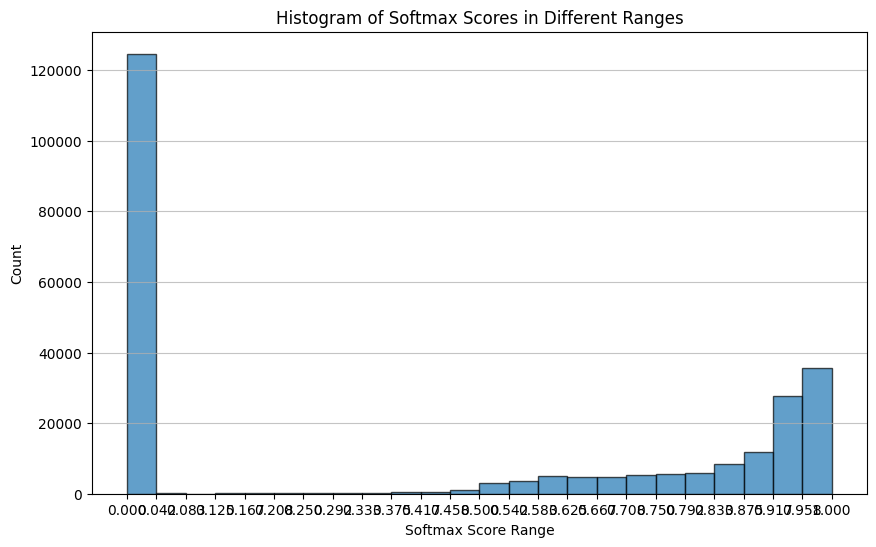

In [8]:
# 测试
import numpy as np
import matplotlib.pyplot as plt
import open3d as o3d
source_path = '../datasets/sequences/00/pre_labels/000001.label'
target_path = '../datasets/sequences/00/velodyne/000000.bin'
src = np.fromfile(source_path, dtype=np.float32)
print(src.shape)
src = src.reshape((-1, 4)) 
src = src[:, :3]
print(src.shape)
dst = np.fromfile(target_path, dtype=np.float32)
print(dst.shape)
dst = dst.reshape((-1, 4))
dst = dst[:, :3]
print(dst.shape)

# point_cloud1 = o3d.geometry.PointCloud()
# point_cloud2 = o3d.geometry.PointCloud()
# point_cloud1.points = o3d.utility.Vector3dVector(src)
# point_cloud2.points = o3d.utility.Vector3dVector(dst)

# point_cloud1.paint_uniform_color([1, 0.706, 0])
# point_cloud2.paint_uniform_color([0, 0.651, 0.929])
# o3d.visualization.draw_geometries([point_cloud1, point_cloud2],
#                                       zoom=0.4459,
#                                       front=[0.9288, -0.2951, -0.2242],
#                                       lookat=[1.6784, 2.0612, 1.4451],
#                                       up=[-0.3402, -0.9189, -0.1996])

distances = nearest_neighbor(src, dst)
distances = np.array(distances).flatten()
softmax_scores = np.exp(-distances) 
print("softmax_scores_shape=",softmax_scores.shape)
print("softmax_scores_dtype=", softmax_scores.dtype)

# np.set_printoptions(precision=10, suppress=True)
# # 输出 softmax_scores 最小的100个值，按从小到大排列
# min_100_scores = np.sort(softmax_scores)[:100]
# # 输出 softmax_scores 最大的100个值，按从大到小排列
# max_100_scores = np.sort(softmax_scores)[-100:][::-1]
# print(min_100_scores)
# print(max_100_scores)

# min_100_dis = np.sort(distances)[:100]
# max_100_dis = np.sort(distances)[-100:][::-1]
# print(min_100_dis)
# print(max_100_dis)

# 使用新的 bins 定义，因为 softmax_scores 的值在 0 到 1 之间
bins_softmax = np.linspace(0, 1, 25)

# 统计 softmax 分数的区间数量
hist_softmax, bin_edges_softmax = np.histogram(softmax_scores, bins=bins_softmax)

# 绘制 softmax 分数的直方图
plt.figure(figsize=(10, 6))
plt.hist(softmax_scores, bins=bins_softmax, edgecolor='black', alpha=0.7)
plt.xlabel('Softmax Score Range')
plt.ylabel('Count')
plt.title('Histogram of Softmax Scores in Different Ranges')
plt.xticks(bins_softmax)
plt.grid(axis='y', alpha=0.75)
plt.show()

colors = np.c_[softmax_scores, np.zeros_like(softmax_scores), 1-softmax_scores]  # 将归一化的sequence距离转换为蓝绿色渐变颜色

# 创建点云对象
point_cloud_src = o3d.geometry.PointCloud()
point_cloud_src.points = o3d.utility.Vector3dVector(src)
point_cloud_src.colors = o3d.utility.Vector3dVector(colors)  # 设置点云颜色

# 可视化
o3d.visualization.draw_geometries([point_cloud_src], 
                                  zoom=0.4459, 
                                  front=[0.9288, -0.2951, -0.2242], 
                                  lookat=[1.6784, 2.0612, 1.4451], 
                                  up=[-0.3402, -0.9189, -0.1996])

In [19]:
import numpy as np
from sklearn.neighbors import NearestNeighbors
import os
import glob


def nearest_neighbor(src, dst):
    
    # assert src.shape == dst.shape
    neigh = NearestNeighbors(n_neighbors=1)
    neigh.fit(dst)
    distances, indices = neigh.kneighbors(src, return_distance=True)
    return distances.ravel(), indices.ravel()

data_list = ['00','01','02','04','05','06','07','09','10']
path = '../datasets/sequences/'

for idx in data_list:
    path_data = os.path.join(path, idx)
    velo_path = os.path.join(path_data, 'velodyne')
    label_path = os.path.join(path_data, 'labels')
    if not os.path.exists(label_path):
        os.makedirs(label_path)
    pre_label_path = os.path.join(path_data, 'pre_labels')
    
    dataset = sorted(glob.glob(os.path.join(velo_path, '*.bin')))
    labelset = sorted(glob.glob(os.path.join(pre_label_path, '*.label')))
    
    print(label_path)

    for i in range(1,len(dataset)):
        src = np.fromfile(labelset[i], dtype=np.float32)
        dst = np.fromfile(dataset[i-1], dtype=np.float32)
        src = src.reshape((-1, 4))
        dst = dst.reshape((-1, 4))
        src = src[:, :3]
        dst = dst[:, :3]
        distances = nearest_neighbor(src, dst)
        distances = np.array(distances)
        distances = distances[0, :]
        
        # print("distances.shape=", distances.shape)
        # print(distances[:10])
       
        softmax_scores = np.exp(-distances) 
        softmax_scores = softmax_scores.astype(np.float32)
        # print("point.shape=", src.shape)
        # print("softmax_scores=", softmax_scores.shape)
        
        softmax_scores.tofile(os.path.join(label_path, '{:06d}.label'.format(i)))

    
        


../datasets/sequences/00/labels
../datasets/sequences/01/labels
../datasets/sequences/02/labels
../datasets/sequences/04/labels
../datasets/sequences/05/labels
../datasets/sequences/06/labels
../datasets/sequences/07/labels
../datasets/sequences/09/labels
../datasets/sequences/10/labels


In [23]:
# 验证
import numpy as np
path = 'Rangenet++/train/tasks/semantic/dataset/sequences'
data_list = ['00','01','02','04','05','06','07','09','10']
for idx in data_list:
    path_data = os.path.join(path, idx)
    velo_path = os.path.join(path_data, 'velodyne')
    label_path = os.path.join(path_data, 'labels')
    dataset = sorted(glob.glob(os.path.join(velo_path, '*.bin')))
    labelset = sorted(glob.glob(os.path.join(label_path, '*.label')))
    for i in range(1,len(dataset)):
        src = np.fromfile(labelset[i], dtype=np.float32)
        dst = np.fromfile(dataset[i], dtype=np.float32)
        src = src.reshape((-1, 4))
        if src.shape[0] != dst.shape[0]:
            print ("序列号：", idx, "帧数：", i)
            print(src.shape, dst.shape)
            print(" ")
            break
        
    
